Cases we can examinate:


nowin_bo0200_P0p16_uoc0p50_reW2.5e4_L10 

re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10 

re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10 

re720_bo0200_P0p08_uoc0p25_reW2.5e4_L11 

re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10 

re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10 

re720_bo0200_P0p08_uoc0p75_reW2.5e4_L10 

re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10 

re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10 

re720_bo0200_P0p16_uoc0p25_reW2.5e4_L11 

re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10 

re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10 

re720_bo0200_P0p16_uoc0p50_reW2.5e4_L11 

re720_bo0200_P0p16_uoc0p75_reW2.5e4_L10 

re720_bo1000_P0p16_uoc0p75_reW2.5e4_L10 

In [1]:
# Librerías estándar y de terceros
import os
import sys
import gc
import math as m
import numpy as np
import scipy
import pandas as pd
from scipy import *
from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from scipy.interpolate import interp1d

import pylab
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
         'axes.labelsize': 33,
         'axes.titlesize':33,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral',  
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, 
}

pylab.rcParams.update(params)
sys.path.append('/projects/DEIKE/cmartinb/functions')
from prepare import load_object, save_object, field
from defs import Case, Interface2D
from phase import extract_phase
from funciones import * 

os.chdir('/projects/DEIKE/cmartinb/')

In [2]:
# DEFINE CASE SO WE CAN AUTHOMATIZE IT 
kpHs = '0p16' # 0p16 
uoc = '0p50' # 0p50 0p75
reW = '2.5e4' #2.5e4 #1.0e5
reA = 720
maxLevel = 10 #11
Bo=200

if reW == '1.0e5':
    Re_water = 1 * 10**5
else:
    Re_water = 2.5 * 10**4

if uoc == '0p75':
    N = 1024
else:
    N = 512 

#Common parameters 
kp = 4
u = 0.5
lambdap = 2*m.pi/kp

L0 = 2*np.pi;


ak, c, omegap, nu_water, g , uoc_val= calculate_parameters(kpHs, uoc , u ,kp)
print('ak is', ak, 'c is' ,c, 'w_p$ is', omegap, '$\nu_w$ is' , nu_water, 'g is' ,g, 'N', N)

ak is 0.16 c is 1.0 w_p$ is 2.0 $
u_w$ is 6.283185307179586e-05 g is 1 N 512


In [3]:
import os

new_folder_path = f'/projects/DEIKE/cmartinb/graphs/2D_spectra/re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}'

if not os.path.exists(new_folder_path):
    # Create the new folder
    os.makedirs(new_folder_path, exist_ok=True)
    print(f"Folder '{new_folder_path}' created successfully.")
else:
    print(f"Folder '{new_folder_path}' already exists.")

Folder '/projects/DEIKE/cmartinb/graphs/2D_spectra/re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10' already exists.


In [4]:
work_dir = f'/projects/DEIKE/nscapin/broadband_reorder/re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}/'
data = np.loadtxt(work_dir+'eta/global_int.out')
#re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10
istep_c =data[:, 1]
time = data[:,0] 
#print(time.shape)
tstart = time[0]

In [5]:
filename_to_check = f'/projects/DEIKE/cmartinb/eta/eta_series_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.npy'

# Check if the file already exists
if not os.path.exists(filename_to_check):
    eta_series = np.zeros((istep_c.shape[0], N, N), dtype=np.float32)
    j = 0
    for i in istep_c:
        filename = work_dir + f'eta/eta_loc/eta_loc_t{int(i):09}.bin'
        etalo = np.fromfile(filename)
        size = etalo.shape
        tot_row = 18
        tot_row_i = int(size[0] / tot_row)
        etalo = etalo.reshape([tot_row_i, tot_row])
        
        eta_m0 = 1.0
        cirp_th = 0.20
        new_row = 0
        for i in range(tot_row_i):
            if abs(etalo[i][12] - eta_m0) < cirp_th:
                new_row += 1
        
        print('iteration', j, "Second pass of remove")
        etal = np.zeros([new_row, 18])
        for i in range(new_row):
            if abs(etalo[i][12] - eta_m0) < cirp_th:
                etal[i][:] = etalo[i][:]
        
        xarray = np.linspace(-L0 / 2., L0 / 2., N, endpoint=False) + L0 / 2 / N / 2  # Centered grid for interpolation
        yarray = np.linspace(-L0 / 2., L0 / 2., N, endpoint=False) + L0 / 2 / N / 2  # Centered grid for interpolation
        xtile, ytile = np.meshgrid(xarray, yarray)
        eta = griddata((etal[:, 0].ravel(), etal[:, 1].ravel()), etal[:, 12].ravel(), (xtile, ytile), method='nearest')
        eta_series[j] = eta
        j += 1
    
    np.save(filename_to_check, eta_series)
else:
    print(f"The file {filename_to_check} already exists. Skipping computation.")

The file /projects/DEIKE/cmartinb/eta/eta_series_re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10.npy already exists. Skipping computation.


In [6]:
eta_series = np.load(f'/projects/DEIKE/cmartinb/eta/eta_series_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.npy', allow_pickle=True)
print(eta_series.shape)


(603, 512, 512)


/tmp/ipykernel_1524668/3213661189.py:100: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,10])


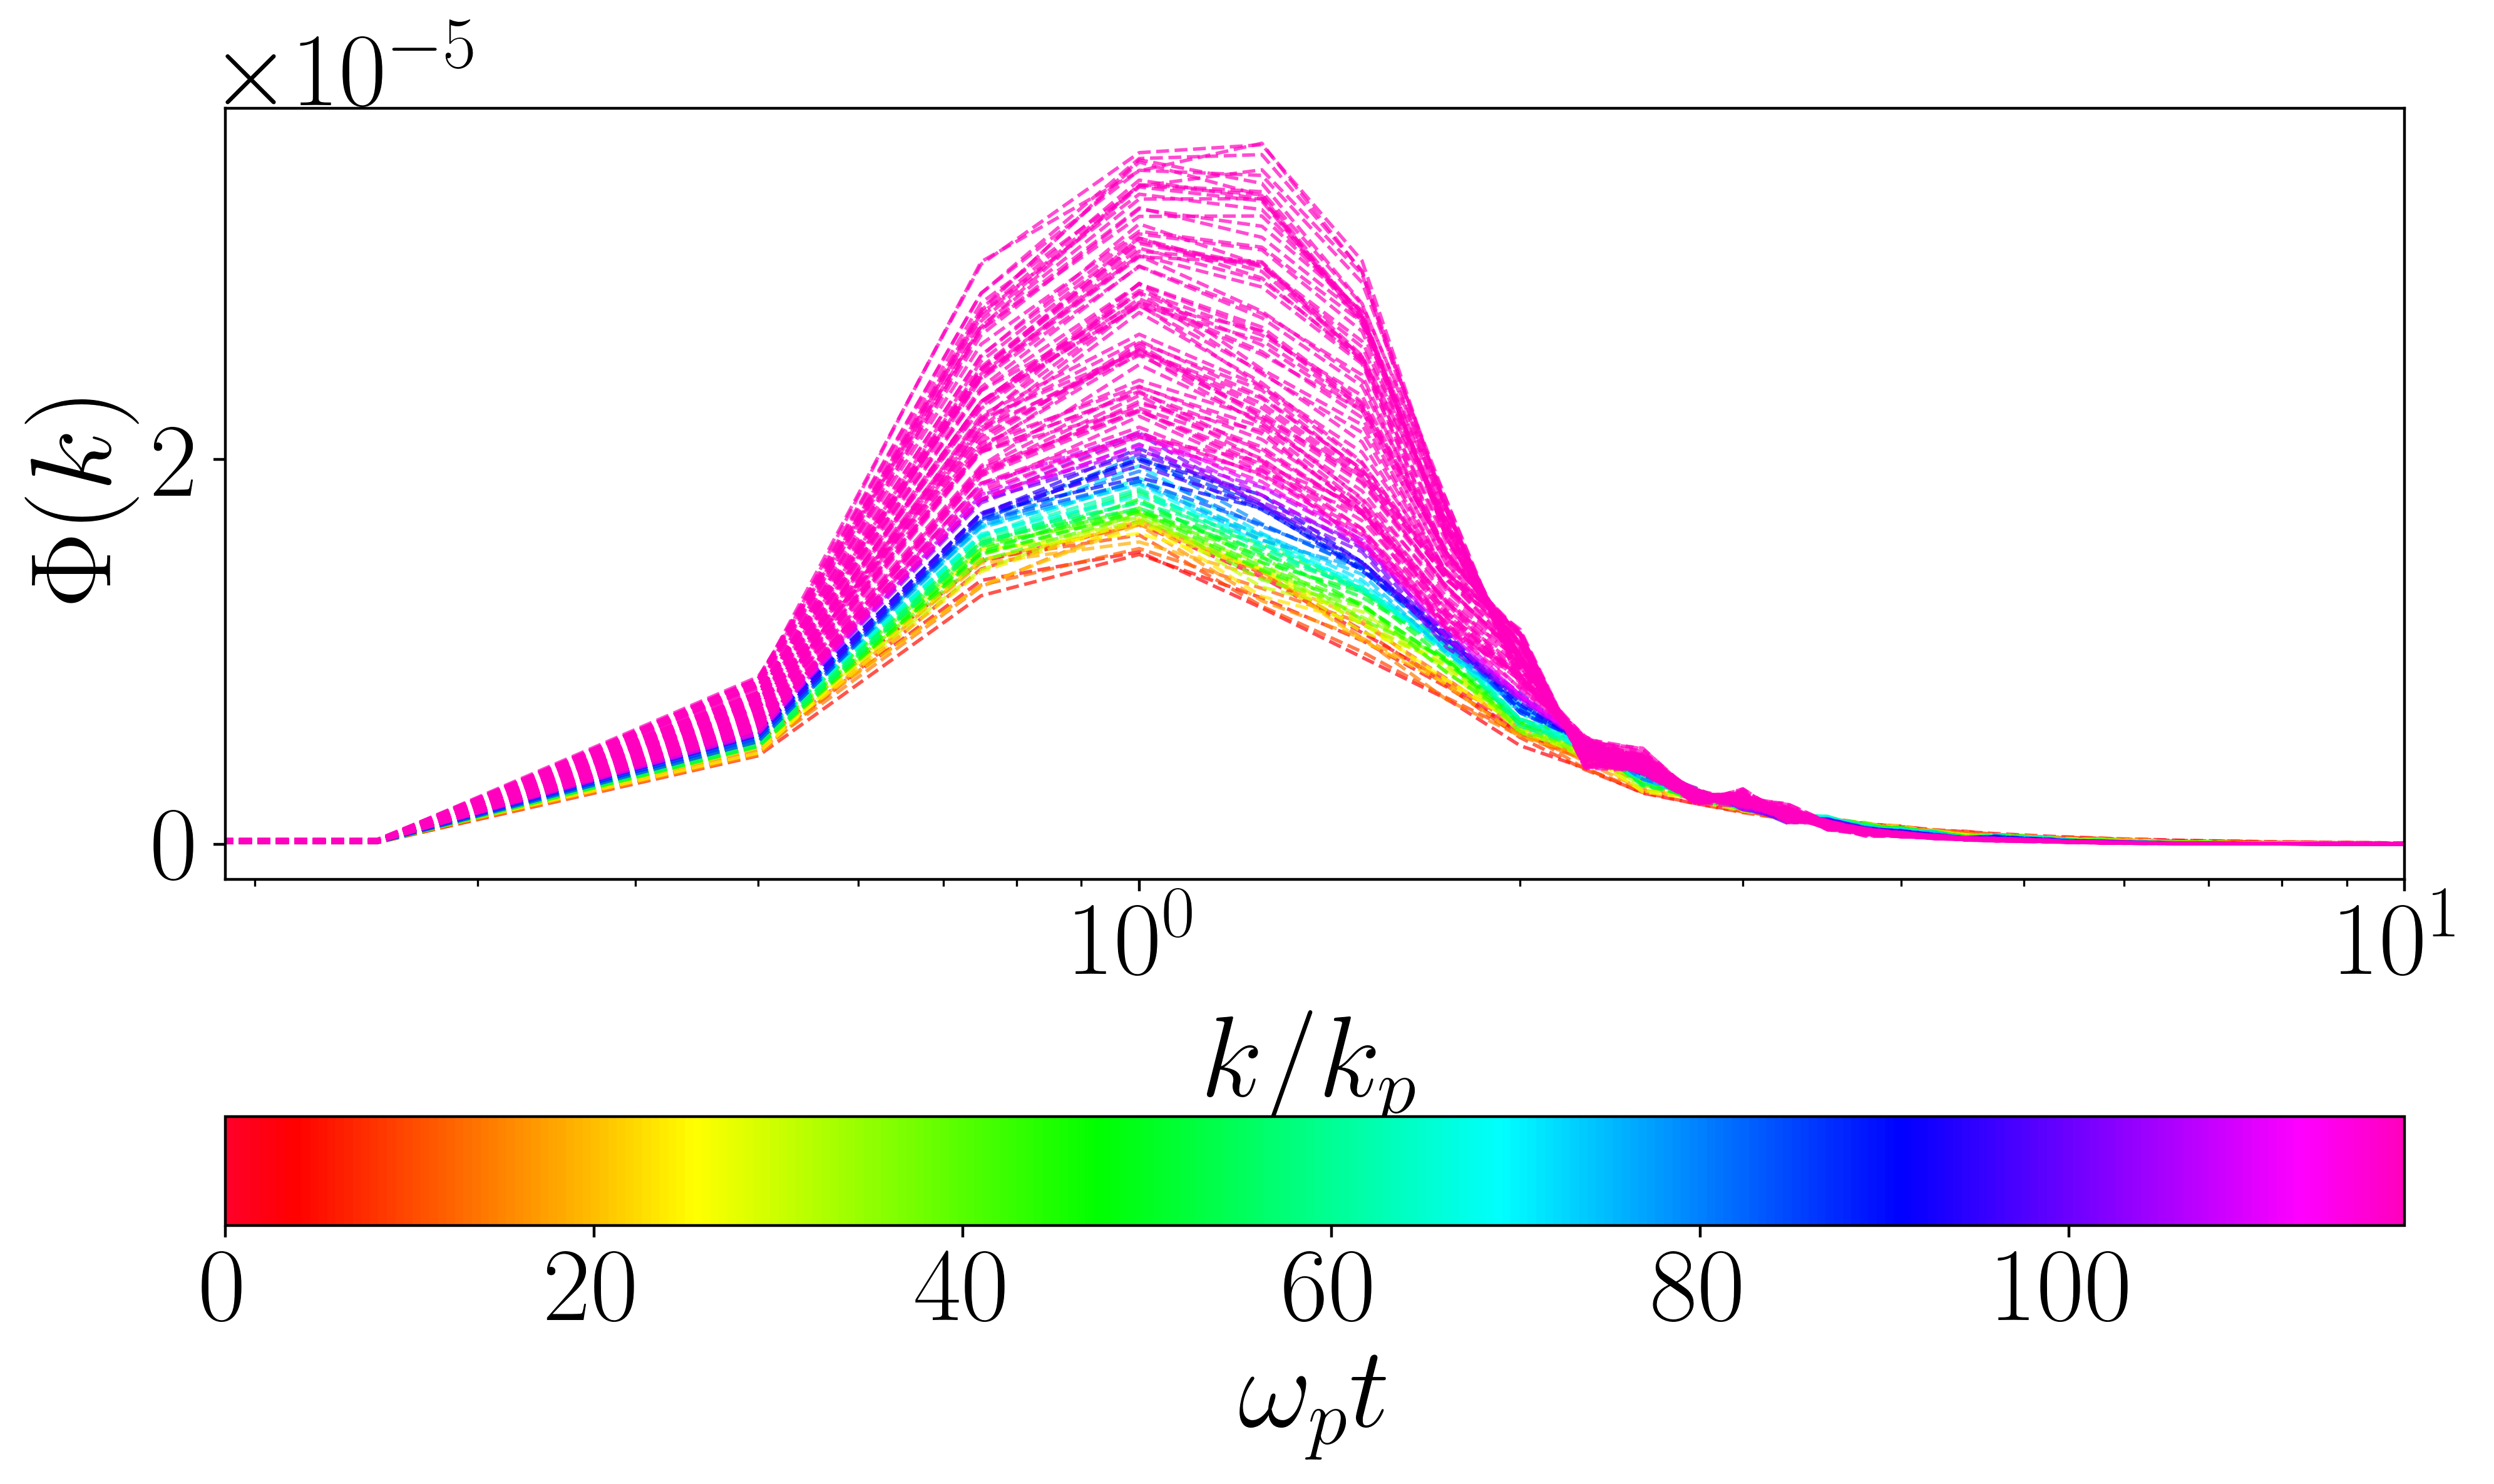

In [7]:
color_map = plt.cm.gist_rainbow
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()

num_rows = 2
num_cols = 3

j = 0

variance = []
integral = []
polar_integral = []
L = 2*m.pi 
# modes growth
energy_mode = []
coordx_mode = []
k_second = []

energy_secondmode = []
coordx_secondmode =[]
pylab.rcParams.update(params)

filtered_coordx_mode = []
filtered_energy_mode = []

#Loop in time


for i in range(len(eta_series)):
    eta = eta_series[i]
    #print(i, variance)
    k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, varr, integ, int_pol , kx, ky = spectrum_integration(
        eta - np.mean(eta), N, L, CHECK=False)
    #print('k', k, 'kx', kx[int(len(kx)/2):])
    #k = kx[int(len(kx)/2):]
    dk = k[1] - k[0]
    
    #print(k)
    if i == 0:

        indices1 = np.arange(0, np.where(k >= 1)[0][0], max(1, int(0.25 / dk)))
        indices10 = np.arange(np.where(k >= 1)[0][0], np.where(k >= 10)[0][0], max(1, int(1 / dk)))
        indices1020 = np.arange(np.where(k >= 10)[0][0], np.where(k > 40)[0][0], max(1, int(1 / dk)))
        indices100 = np.arange(np.where(k >= 20)[0][0], np.where(k > 100)[0][0], max(1, int(10/ dk)))
        indicesplus = np.arange(np.where(k >= 100)[0][0], len(k), max(1, int(20 / dk)))

        k_multiples = np.concatenate((indices1, indices10, indices1020 ,indices100, indicesplus))

        k_multiples = k_multiples.astype(int)
        # Obtener los valores de k y las energías correspondientes
        k_seleccionados = k[k_multiples]

    energias_correspondientes = F_center_polar_integrated[k_multiples]
    #k = k/4
    
    if i == 0:
        E0_both = np.sum(F_center_polar_integrated) * dk
        #print(type(indices_cada_diez))
        E0_nodes_both = F_center_polar_integrated[k_multiples]
        #E0_second_both =  F_center_polar_integrated[k_second]
    
    if i % 5 == 0:
        psd = ax.plot(k/4, F_center_polar_integrated, '--', color=plt.cm.get_cmap('gist_rainbow')(j), alpha=0.7, linewidth=1)
    
    energy_mode.append(energias_correspondientes.tolist())
    #coordx_mode.append(coordx.tolist())
    integral.append(integ)
    variance.append(varr)
    polar_integral.append(int_pol)
 
    j += 1

# plot where are the nodes

#for km in k_seleccionados:
    #plt.axvline(x=km, color='gray', linestyle='--', linewidth=0.3)
    
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
#plt.legend(loc='upper right', fontsize=4)


color_values =  (omegap*(np.array(time)-time[0]))

# Now set the normalization with the correct range

norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])  

# Add the colorbar to the figure
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)

# Set colorbar label and other properties if needed
cbar.set_label('$\omega_{p} t$')


fig.tight_layout()
cbar.set_label('$\omega_{p} t$')
plt.xscale('log')
plt.xlim([0,10])
#plt.ylim([10**-11,10**-3])
#plt.yscale('log')
plt.xlabel('$\mathdefault{k/k_{p}}$')
plt.ylabel('$\mathdefault{\Phi(k)}$')
fig.tight_layout()

In [ ]:
from scipy.interpolate import interp1d
from scipy import integrate
import csv

fig = plt.figure(figsize=(10, 6))
color_map = plt.cm.gist_rainbow
ax = fig.gca()

num_rows = 2
num_cols = 3

j = 0

variance = []
integral = []
polar_integral = []

k_seleccionados =[]

# modes growth
energy_interval_time = []
coordx_mode = []
k_second = []

energy_secondmode = []
coordx_secondmode =[]

F_mode =[]
filtered_coordx_mode = []
filtered_energy_mode = []

E_interval = []

with open(f'/projects/DEIKE/cmartinb/energies/eta_series_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}_energies.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for i in range(len(eta_series)):

        #recorre el tiempo

        eta = eta_series[i]

        k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, varr, integ, int_pol , kx, ky = spectrum_integration(
            eta - np.mean(eta), N, L, CHECK=False)

        E_interval = []

        #print(i)

        for m in range(41):
            if m == 0:
                # Primer punto
                idx_start, idx_end = 0, 1
            elif m == len(k) - 1:
                # Último punto
                idx_start, idx_end = m - 1, m
            else:
                # Puntos intermedios
                idx_start, idx_end = m - 1, m + 1
                
            F_integral_interval = integrate.trapezoid(F_center_polar_integrated[idx_start:idx_end+1], k[idx_start:idx_end+1])
            
            #print('idx start',idx_start, 'idx end', idx_end )
            
            k_seleccionados.append(k[m]) # lista con la energia de cada intervalo [IN .....IN]

            psd = ax.plot(k/4, F_center_polar_integrated, '--', color=plt.cm.get_cmap('gist_rainbow')(j), alpha=0.7, linewidth=0.3)

            #ax.axvline(x = k[m]/4, color = 'grey', alpha =0.3)
            
            #print('k[idx_start]',k[idx_start],'k[idx_end]', k[idx_end])
            
            #print('i',i,'interval' ,k[idx_start:idx_end+1], 'F_center_polar_integrated',F_center_polar_integrated[idx_start:idx_end+1], 'F ingrated interpol', F_integral_interval,'l',m)

            E_interval.append(F_integral_interval)
            
            writer.writerow([i, m, F_integral_interval, omegap*(time[i]-time[0])])
            
            #f.write(interval_str)
        
        energy_interval_time.append(E_interval) #lista con la energia de todos intervalos para cada tiempo [[I1.... IN]_0.....[IN...IN]_N] en tiempo i

        #writer.writerow(E_interval)
        
        
        j += 1

# plot where are the nodes

for km in k_seleccionados:
    ax.axvline(x=km/4, color='gray', linestyle='--', linewidth=0.3)

ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
#plt.legend(loc='upper right', fontsize=4)


color_values =  (omegap*(np.array(time)-time[0]))

# Now set the normalization with the correct range

norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])  

# Add the colorbar to the figure
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)

# Set colorbar label and other properties if needed
cbar.set_label('$\omega_{p} t$')


fig.tight_layout()
cbar.set_label('$\omega_{p} t$')
plt.xscale('log')
plt.xlim([0,10])
#plt.ylim([10**-8,1])
plt.yscale('log')
plt.xlabel('$\mathdefault{k/k_{p}}$')
plt.ylabel('$\mathdefault{\Phi(k)}$')
fig.tight_layout()

In [ ]:
df = pd.read_csv(f'/projects/DEIKE/cmartinb/energies/eta_series_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}_energies.csv', names=['i', 'k', 'F_integral_interval', 'time'])

In [ ]:
# Crear una columna de grupo para cada 'i' que indique el número de intervalo
df['interval_num'] = df.groupby('i').cumcount()

# Ahora pivotar el DataFrame para que cada fila sea una 'i' y cada columna un intervalo
df_pivot = df.pivot(index='i', columns='interval_num', values='F_integral_interval')

# Si deseas que el DataFrame resultante tenga únicamente los valores de integración sin los índices de intervalos como nombres de columnas
df_pivot.columns = [f'interval_{i}' for i in range(len(df_pivot.columns))]

# Resetea el índice para que 'i' sea una columna normal en lugar de un índice
df_pivot = df_pivot.reset_index()

In [ ]:
from scipy.optimize import curve_fit

# Asumiendo que 'df_pivot' es tu DataFrame y que 'time' y 'k_seleccionados' están definidos
colormap = cm.viridis
normalize = plt.Normalize(vmin=0, vmax=(len(df_pivot.columns) - 2)/4)  # normalizar basado en el número de intervalos

# Crear una figura y un eje para el ploteo
fig, ax = plt.subplots(figsize=(14, 7))

# Definir la función del modelo exponencial
def exp_model(x, a, b):
    return a * np.exp(b * x)

# Crear listas para almacenar los parámetros de crecimiento y decadencia
beta_growth = []
beta_decay = []

k_growth = []
k_decay = []

# Iterar sobre cada intervalo y realizar ajuste exponencial
for idx, column in enumerate(df_pivot.columns[1:]):  # Ignora la primera columna que es 'i'
    # Extraer datos para el intervalo actual
    mode_total_norm = df_pivot[column].dropna()  # Eliminar valores NaN por seguridad
    tiempo_valido = omegap*(time[:len(mode_total_norm)-1]-tstart)  # Asegurar que tiempo y mode_total_norm tengan la misma longitud
    
    mode_total_norm = mode_total_norm[:-1]
    
    # Ajuste exponencial solo si todos los valores son positivos y hay suficientes datos
    if len(mode_total_norm) > 1 and np.all(mode_total_norm > 0):
        popt, pcov = curve_fit(exp_model, tiempo_valido, mode_total_norm, p0=(1, 0.001), maxfev=100000)
        a, b = popt
        if b > 0:
            beta_growth.append(b)
            k_growth.append(idx)
        else:
            beta_decay.append(b)
            k_decay.append(idx)
        
        # Realizar gráfico para cada intervalo
        color = cm.viridis(idx / len(df_pivot.columns[1:]))  # Normalizar color
        ax.scatter(tiempo_valido, mode_total_norm, color=color, s=10)
        ax.plot(tiempo_valido, exp_model(tiempo_valido, *popt), color=color, lw=2)

# Configurar gráfico
ax.set_xlabel('Time')
ax.set_ylabel('E(t)')
ax.set_title('Exponential Fit of Integration Over Intervals')
plt.colorbar(cm.ScalarMappable(norm=normalize, cmap=colormap), label='k/kp')
#plt.legend()
plt.show()

# Imprimir los valores de beta para crecimiento y decadencia
print("Growth betas:", beta_growth)
print("Decay betas:", beta_decay)
print("Growth k:", k_growth)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit

# Asumiendo que 'df_pivot' es tu DataFrame y que 'time' y 'k_seleccionados' están definidos
colormap = cm.viridis
normalize = plt.Normalize(vmin=0, vmax=(len(df_pivot.columns) - 2)/4)  # normalizar basado en el número de intervalos

# Crear una figura y un eje para el ploteo
fig, ax = plt.subplots(figsize=(14, 7))

# Definir la función del modelo exponencial
def exp_model(x, a, b):
    return a * np.exp(b * x)

# Crear listas para almacenar los parámetros de crecimiento y decadencia
beta_growth = []
beta_decay = []

k_growth = []
k_decay = []

# Iterar sobre cada intervalo y realizar ajuste exponencial
for idx, column in enumerate(df_pivot.columns[1:]):  # Ignora la primera columna que es 'i'
    # Extraer datos para el intervalo actual
    mode_total_norm = df_pivot[column].dropna()  # Eliminar valores NaN por seguridad
    tiempo_valido = omegap*(time[:len(mode_total_norm)]-tstart)  # Asegurar que tiempo y mode_total_norm tengan la misma longitud
    
    # Ajuste exponencial solo si todos los valores son positivos y hay suficientes datos
    if len(mode_total_norm) > 1 and np.all(mode_total_norm > 0):
        popt, pcov = curve_fit(exp_model, tiempo_valido, mode_total_norm, p0=(1, 0.001), maxfev=10000)
        a, b = popt
        if b > 0:
            beta_growth.append(b)
            k_growth.append(idx)
        else:
            beta_decay.append(b)
            k_decay.append(idx)
        
        # Realizar gráfico para cada intervalo
        color = cm.viridis(idx / len(df_pivot.columns[1:]))  # Normalizar color
        ax.scatter(tiempo_valido, mode_total_norm, color=color, s=10)
        ax.plot(tiempo_valido, exp_model(tiempo_valido, *popt), color=color, lw=2)

# Configurar gráfico
ax.set_xlabel(r'$\omega_{p} t$')
ax.set_ylabel(r'$E_{k}(t)$')
ax.set_title('Evolution energy over time for each mode')
plt.colorbar(cm.ScalarMappable(norm=normalize, cmap=colormap), label='k/kp')
#plt.legend()

plt.yscale('log')

plt.show()
# Imprimir los valores de beta para crecimiento y decadencia
print("Growth betas:", beta_growth)
print("Decay betas:", beta_decay)
print("Growth k:", k_growth)
print("Decay k:", k_decay)

In [ ]:
import pandas as pd
import numpy as np

# Creation Df for growth and decay
df_growth = pd.DataFrame({
    'Tipo': 'Growth',
    'Beta': beta_growth,
    'k': k_growth
})

df_decay = pd.DataFrame({
    'Tipo': 'Decay',
    'Beta': beta_decay,
    'k': k_decay
})

df_beta = pd.concat([df_growth, df_decay], axis=0).reset_index(drop=True)

# Guardar el DataFrame combinado en un archivo CSV
df_beta.to_csv(f'/projects/DEIKE/cmartinb/betas/betas_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.csv', index=False)

In [ ]:
print(f'/projects/DEIKE/cmartinb/betas/betas_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
plt.scatter([k/4 for k in k_growth], [beta/omegap for beta in beta_growth], c='darkblue', marker= "^", label=r'Growth $\omega t$', alpha=0.6, edgecolors='w', s=100)
plt.scatter([k/4 for k in k_decay], [beta/omegap for beta in beta_decay], c='darkred', marker= "^", label=r'Decay $\omega t$ ', alpha=0.6, edgecolors='w', s=100)
# Añadir etiquetas y título
plt.xlabel(r'$k/k_p$', fontsize=14)
plt.ylabel(r'$\beta / \omega_{p}$', fontsize=14)
plt.title(f'Growth and Decay Rates by Wavenumber ak = {ak}, u/c ={u/c}', fontsize=16)
plt.axvline(x=1, color='blue', linestyle='--', linewidth=1, alpha= 0.4,  label=r'$k/k_{p}=1$')
# Añadir leyenda
plt.legend()

# Añadir cuadrícula para mejor visualización
plt.grid(True)

# Ajustar límites si es necesario
#plt.xlim([-0.2, 0.2])
#plt.ylim([-0.008, 0.008])
#plt.savefig(f'/projects/DEIKE/cmartinb/graphs/2D_spectra/re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}/growth_rate.png')

# Mostrar el gráfico
plt.show()

In [ ]:
df_beta_kpHs016_upc05 = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.csv')

df_growth_kpHs016_upc05 = df_beta_kpHs016_upc05[df_beta_kpHs016_upc05['Tipo'] == 'Growth']
df_decay_kpHs016_upc05 = df_beta_kpHs016_upc05[df_beta_kpHs016_upc05['Tipo'] == 'Decay']

k_growth_kpHs016_upc05 = df_growth_kpHs016_upc05['k']
k_decay_kpHs016_upc05 = df_decay_kpHs016_upc05['k']
beta_growth_kpHs016_upc05 = df_growth_kpHs016_upc05['Beta']
beta_decay_kpHs016_upc05 = df_decay_kpHs016_upc05['Beta']

fig, ax = plt.subplots(figsize=(14, 7))
plt.scatter([k/4 for k in k_growth], [beta/omegap for beta in beta_growth], c='navy', marker= "^", label=r'Growth $\omega t$ $Re = 1.05 \cdot 10^{5}$', alpha=0.8, edgecolors='w', s=100)
plt.scatter([k/4 for k in k_decay], [beta/omegap for beta in beta_decay], c='darkred', marker= "v", label=r'Decay $\omega t$  $Re = 1.05 \cdot 10^{5}$', alpha=0.8, edgecolors='w', s=100)
plt.scatter([k/4 for k in k_growth_kpHs016_upc05], [beta/omegap for beta in beta_growth_kpHs016_upc05], c='turquoise', marker= "^", label=r'Growth $\omega t$ $Re = 2.5 \cdot 10^{4}$', alpha=0.8, edgecolors='w', s=100)
plt.scatter([k/4 for k in k_decay_kpHs016_upc05], [beta/omegap for beta in beta_decay_kpHs016_upc05], c='deeppink', marker= "v", label=r'Decay $\omega t$  $Re = 2.5 \cdot 10^{4}$', alpha=0.8, edgecolors='w', s=100)
# Añadir etiquetas y título
plt.xlabel(r'$k/k_p$', fontsize=14)
plt.ylabel(r'$\beta / \omega_{p}$', fontsize=14)
#plt.title(f'Growth and Decay Rates by Wavenumber ak = {kpHs}, u/c ={uoc}', fontsize=16)
plt.axvline(x=1, color='blue', linestyle='--', linewidth=1, alpha= 0.4,  label=r'$k/k_{p}=1$')
# Añadir leyenda
plt.legend()

# Añadir cuadrícula para mejor visualización
plt.grid(True)

# Ajustar límites si es necesario
#plt.xlim([-0.2, 0.2])
#plt.ylim([-0.05, 0.01])
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/2D_spectra/growth_rate_diffRe_{kpHs}_{uoc}.png')

# Mostrar el gráfico
plt.show()


In [ ]:
import math as m
# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
         'axes.labelsize': 33,
         'axes.titlesize':33,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral',  
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, 
}

pylab.rcParams.update(params)
cases = [
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '').replace('e', r'\times 10^')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")
    
    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10**4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Define color map
colors = plt.cm.get_cmap('tab10', len(cases))

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Define growth and decay
    df_growth = df_beta[df_beta['Tipo'] == 'Growth']
    df_decay = df_beta[df_beta['Tipo'] == 'Decay']

    k_growth = df_growth['k']
    k_decay = df_decay['k']
    beta_growth = df_growth['Beta']
    beta_decay = df_decay['Beta']

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Plotting
    color = colors(idx)
    plt.scatter([k/4 for k in k_growth], [beta/omegap for beta in beta_growth], c=[color], marker= "^", label=f'$ k_pHs={kpHs}, u*/c={uoc_val}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)
    plt.scatter([k/4 for k in k_decay], [beta/omegap for beta in beta_decay], c=[color], marker= "v",  alpha=0.8, edgecolors='w', s=100)

# Add labels and title
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$\beta / \omega_{p}$')

#plt.title(f'$Re_{{a}}={reA} Bo={Bo}  L={maxLevel}$')
plt.legend(loc='lower left', prop={'size': 17})

# Add grid for better visualization
plt.grid(True)

# Adjust limits if necessary
#plt.yscale('log')
#plt.xlim([-0.2, 7])
#plt.ylim([-0.008, 0.008])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/betaomegap_kkp_Rea{reA}_Bo{Bo}_L{maxLevel}.png')
# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pylab

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]


# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel


# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")

    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10 ** 4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val


# Function to find the value of k whose beta is closest to 0, excluding k = 0
def find_k_closest_to_zero(k_values, beta_values):
    mask = k_values != 0
    k_values = k_values[mask]
    beta_values = beta_values[mask]
    abs_beta = np.abs(beta_values)
    min_index = np.argmin(abs_beta)
    return k_values[min_index]


# Function to convert reW to numeric value
def convert_reW_to_numeric(reW):
    base, exponent = reW.split('e')
    return float(base) * 10 ** float(exponent)


# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Define color map
colors = plt.cm.get_cmap('tab10', len(cases))

# List to store crossing points
crossing_points = []

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Find the value of k whose beta is closest to 0
    k_cross = find_k_closest_to_zero(k_combined, beta_combined)

    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_cross/4))

    # Plotting
    color = colors(idx)
    y_values = [(beta)/omegap  for beta, k in zip(beta_combined, k_combined)]
    plt.scatter([k / 4 for k in k_combined], y_values, c=[color], marker="^",
                label=f'$ k_pHs={kpHs}, u*/c={uoc_val}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

    # Plot red crosses for crossing points
    plt.scatter(k_cross / 4, 0, c='red', marker='x', s=200, edgecolors='w')

# Add labels and title
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$\beta / \omega_{p}$')

#plt.title(f'$Re_{{a}}={reA} Bo={Bo}  L={maxLevel}$')
plt.legend(loc='lower left', prop={'size': 17})

# Add grid for better visualization
plt.grid(True)

# Adjust limits if necessary
#plt.xlim([-0.2, 5])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/k_crossing_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Show the plot
plt.show()

# Check the crossing points
print("Crossing Points:")
for point in crossing_points:
    print(point)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pylab

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]


# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel


# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")

    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10 ** 4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val


# Function to find the value of k whose beta is closest to 0, excluding k = 0
def find_k_closest_to_zero(k_values, beta_values):
    mask = k_values != 0
    k_values = k_values[mask]
    beta_values = beta_values[mask]
    abs_beta = np.abs(beta_values)
    min_index = np.argmin(abs_beta)
    return k_values[min_index]


# Function to convert reW to numeric value
def convert_reW_to_numeric(reW):
    base, exponent = reW.split('e')
    return float(base) * 10 ** float(exponent)


# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Define color map
colors = plt.cm.get_cmap('tab10', len(cases))

# List to store crossing points
crossing_points = []

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Find the value of k whose beta is closest to 0
    k_cross = find_k_closest_to_zero(k_combined, beta_combined)

    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_cross/4))

    # Plotting
    color = colors(idx)
    plt.scatter([k / 4 for k in k_combined], [beta / omegap for beta in beta_combined], c=[color], marker="^",
                label=f'$ k_pHs={kpHs}, u*/c={uoc_val}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

    # Plot red crosses for crossing points
    plt.scatter(k_cross / 4, 0, c='red', marker='x', s=200, edgecolors='w')

# Add labels and title
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$\beta / \omega_{p}$')

#plt.title(f'$Re_{{a}}={reA} Bo={Bo}  L={maxLevel}$')
plt.legend(loc='lower left', prop={'size': 17})

# Add grid for better visualization
plt.grid(True)

# Adjust limits if necessary
plt.xlim([-0.2, 5])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/k_crossingzoom_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Show the plot
plt.show()

# Check the crossing points
print("Crossing Points:")
for point in crossing_points:
    print(point)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pylab

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")

    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10 ** 4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Function to find the value of k whose beta is closest to 0, excluding k = 0
def find_k_closest_to_zero(k_values, beta_values):
    mask = k_values != 0
    k_values = k_values[mask]
    beta_values = beta_values[mask]
    abs_beta = np.abs(beta_values)
    min_index = np.argmin(abs_beta)
    return k_values[min_index]

# Function to convert reW to numeric value
def convert_reW_to_numeric(reW):
    base, exponent = reW.split('e')
    return float(base) * 10 ** float(exponent)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Define color map
colors = plt.cm.get_cmap('tab10', len(cases))

# List of markers
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']

# List to store crossing points
crossing_points = []

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Find the value of k whose beta is closest to 0
    k_cross = find_k_closest_to_zero(k_combined, beta_combined)

    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_cross / 4))

    # Plotting
    color = colors(idx % len(cases))
    marker = markers[idx % len(markers)]
    plt.scatter([k / 4 for k in k_combined], [beta / omegap for beta in beta_combined], c=[color], marker=marker,
                label=f'$ k_pHs={kpHs}, u*/c={uoc_val}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

    # Plot red crosses for crossing points
    plt.scatter(k_cross / 4, 0, c='red', marker='x', s=200, edgecolors='w')

# Add labels and title
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$\beta / \omega_{p}$')

#plt.title(f'$Re_{{a}}={reA} Bo={Bo}  L={maxLevel}$')
plt.legend(loc='lower left', prop={'size': 17})

# Add grid for better visualization
plt.grid(True)

# Adjust limits if necessary
plt.xlim([-0.2, 5.5])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/k_crossingzoom_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Show the plot
plt.show()

# Check the crossing points
print("Crossing Points:")
for point in crossing_points:
    print(point)

# Convert reW to numeric values for plotting
numeric_reW = [convert_reW_to_numeric(reW) for _, _, _, reW, _ in crossing_points]

# Generate unique colors and markers for each combination for each graph
# 1. uoc and reW
labels_uoc_reW = [f'$u*/c={uoc}$ and $Re_{{w}}={reW}$' for _, _, uoc, reW, _ in crossing_points]
unique_labels_uoc_reW = list(set(labels_uoc_reW))
color_marker_map_uoc_reW = {label: (colors(i % len(cases)), markers[i % len(markers)]) for i, label in enumerate(unique_labels_uoc_reW)}

# 2. kpHs and reW
labels_kpHs_reW = [f'$k_pH_s={kpHs}$ and $Re_{{w}}={reW}$' for _, kpHs, _, reW, _ in crossing_points]
unique_labels_kpHs_reW = list(set(labels_kpHs_reW))
color_marker_map_kpHs_reW = {label: (colors(i % len(cases)), markers[i % len(markers)]) for i, label in enumerate(unique_labels_kpHs_reW)}

# 3. kpHs and uoc
labels_kpHs_uoc = [f'$k_pH_s={kpHs}$ and $u*/c={uoc}$' for _, kpHs, uoc, _, _ in crossing_points]
unique_labels_kpHs_uoc = list(set(labels_kpHs_uoc))
color_marker_map_kpHs_uoc = {label: (colors(i % len(cases)), markers[i % len(markers)]) for i, label in enumerate(unique_labels_kpHs_uoc)}

# Plot k characteristic vs kpHs
fig2, ax2 = plt.subplots(figsize=(14, 7))
for idx, (case, kpHs, uoc, reW, k_cross) in enumerate(crossing_points):
    label = f'$u*/c={uoc}$ and $Re_{{w}}={reW}$'
    color, marker = color_marker_map_uoc_reW[label]
    ax2.plot(float(kpHs), k_cross, marker=marker, c=color, markersize=15, alpha=0.8, linestyle='-', label=label)
handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), prop={'size': 17})
ax2.set_xlabel(r'$k_pHs$')
ax2.set_ylabel(r'$k_{c}$')
ax2.grid(True)
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/characteristic_k_vs_kpHs_Rea{reA}_Bo{Bo}_L{maxLevel}.png')
plt.show()

# Plot k characteristic vs uoc
fig3, ax3 = plt.subplots(figsize=(14, 7))
for idx, (case, kpHs, uoc, reW, k_cross) in enumerate(crossing_points):
    label = f'$k_pH_s={kpHs}$ and $Re_{{w}}={reW}$'
    color, marker = color_marker_map_kpHs_reW[label]
    ax3.plot(float(uoc), k_cross, marker=marker, c=color, markersize=15, alpha=0.8, linestyle='--', label=label)
handles, labels = ax3.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys(), prop={'size': 17})
ax3.set_xlabel(r'$u^*/c$')
ax3.set_ylabel(r'$k_{c}$')
ax3.grid(True)
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/characteristic_k_vs_uoc_Rea{reA}_Bo{Bo}_L{maxLevel}.png')
plt.show()

# Plot k characteristic vs reW
fig4, ax4 = plt.subplots(figsize=(14, 7))
for idx, (case, kpHs, uoc, reW, k_cross) in enumerate(crossing_points):
    label = f'$k_pH_s={kpHs}$ and $u*/c={uoc}$'
    color, marker = color_marker_map_kpHs_uoc[label]
    ax4.plot(numeric_reW[idx], k_cross, marker=marker, c=color, markersize=15, alpha=0.8, linestyle='--', label=label)
handles, labels = ax4.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax4.legend(by_label.values(), by_label.keys(), prop={'size': 17})
ax4.set_xlabel(r'$Re_w$')
ax4.set_ylabel(r'$k_{c}$')
ax4.grid(True)
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/characteristic_k_vs_reW_Rea{reA}_Bo{Bo}_L{maxLevel}.png')
plt.show()

# Display the crossing points
for case, kpHs, uoc, reW, k_cross in crossing_points:
    print(f'Caso: {case}, k donde beta cruza el eje y: {k_cross}')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pylab

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]


# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel


# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")

    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10 ** 4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val


# Function to find the value of k whose beta is closest to 0, excluding k = 0
def find_k_closest_to_zero(k_values, beta_values):
    mask = k_values != 0
    k_values = k_values[mask]
    beta_values = beta_values[mask]
    abs_beta = np.abs(beta_values)
    min_index = np.argmin(abs_beta)
    return k_values[min_index]


# Function to convert reW to numeric value
def convert_reW_to_numeric(reW):
    base, exponent = reW.split('e')
    return float(base) * 10 ** float(exponent)


# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Define color map
colors = plt.cm.get_cmap('tab10', len(cases))

# List to store crossing points
crossing_points = []

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Find the value of k whose beta is closest to 0
    k_cross = find_k_closest_to_zero(k_combined, beta_combined)

    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_cross/4))

    # Plotting
    color = colors(idx)
    y_values = [(beta + 4 * nu_water * k**2)/omegap  for beta, k in zip(beta_combined, k_combined)]
    plt.scatter([k / 4 for k in k_combined], y_values, c=[color], marker="^",
                label=f'$ k_pHs={kpHs}, u*/c={uoc_val}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

    # Plot red crosses for crossing points
    #plt.scatter(k_cross / 4, 0, c='red', marker='x', s=200, edgecolors='w')

# Add labels and title
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$(\beta + 4\nu k^{2}) / \omega_{p}$')

#plt.title(f'$Re_{{a}}={reA} Bo={Bo}  L={maxLevel}$')
plt.legend(loc='upper left', prop={'size': 17})

# Add grid for better visualization
plt.grid(True)
#plt.yscale('log')
# Adjust limits if necessary
#plt.xlim([-0.2, 5])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/beta_compensated_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Show the plot
plt.show()

# Check the crossing points
#print("Crossing Points:")
#for point in crossing_points:
    #print(point)

# Normalization by the frequency, we have to load it from the folder omega, NOT OMEGA_MODES.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pylab

# Parámetros de configuración para los gráficos
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Función para extraer parámetros del nombre del caso
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Función existente para calcular parámetros
def calculate_parameters(kpHs, uoc, u, kp):
    # Convertir kpHs y uoc a sus valores numéricos
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determinar el valor de g basado en uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")

    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10 ** 4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Función para encontrar el valor de k cuyo beta es más cercano a 0, excluyendo k = 0
def find_k_closest_to_zero(k_values, beta_values):
    mask = k_values != 0
    k_values = k_values[mask]
    beta_values = beta_values[mask]
    abs_beta = np.abs(beta_values)
    min_index = np.argmin(abs_beta)
    return k_values[min_index]

# Inicializar el gráfico
fig, ax = plt.subplots(figsize=(14, 7))

# Definir mapa de colores
colors = plt.cm.get_cmap('tab10', len(cases))

# Lista para almacenar puntos de cruce
crossing_points = []

# Loop a través de cada caso
for idx, case in enumerate(cases):
    # Leer los datos
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')
    
    # Imprimir las columnas del DataFrame para verificar la presencia de 'Omega'
    #print(f"Columnas del archivo {case}: {df_beta.columns.tolist()}")

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega_combined = df_combined['Omega'].values
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    u = 0.5 
    kp = 4 
    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Find the value of k whose beta is closest to 0
    k_cross = find_k_closest_to_zero(k_combined, beta_combined)

    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_cross / 4))

    # Plotting
    color = colors(idx)
    y_values = [(beta + 4 * nu_water * k ** 2) / omega for beta, k, omega in zip(beta_combined, k_combined, omega_combined)]
    plt.scatter([k / 4 for k in k_combined], y_values, c=[color], marker="^",
                label=f'$ k_pHs={kpHs}, u*/c={uoc_val}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

# Agregar etiquetas y título
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$(\beta + 4\nu k^{2}) / \omega$')

plt.legend(loc='upper left', prop={'size': 17})

# Agregar cuadrícula para mejor visualización
plt.grid(True)

# Guardar el gráfico
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/beta_compensated_omega_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Mostrar el gráfico
plt.show()

# Verificar los puntos de cruce
#print("Crossing Points:")
#for point in crossing_points:
    #print(point)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pylab

# Parámetros de configuración para los gráficos
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Función para extraer parámetros del nombre del caso
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Función existente para calcular parámetros
def calculate_parameters(kpHs, uoc, u, kp):
    # Convertir kpHs y uoc a sus valores numéricos
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determinar el valor de g basado en uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")

    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10 ** 4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Función para encontrar el valor de k cuyo beta es más cercano a 0, excluyendo k = 0
def find_k_closest_to_zero(k_values, beta_values):
    mask = k_values != 0
    k_values = k_values[mask]
    beta_values = beta_values[mask]
    abs_beta = np.abs(beta_values)
    min_index = np.argmin(abs_beta)
    return k_values[min_index]

# Inicializar el gráfico
fig, ax = plt.subplots(figsize=(14, 7))

# Definir mapa de colores
colors = plt.cm.get_cmap('tab10', len(cases))

# Lista para almacenar puntos de cruce
crossing_points = []

# Loop a través de cada caso
for idx, case in enumerate(cases):
    # Leer los datos
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')
    
    # Imprimir las columnas del DataFrame para verificar la presencia de 'Omega'
    #print(f"Columnas del archivo {case}: {df_beta.columns.tolist()}")

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega_combined = df_combined['Omega'].values
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Find the value of k whose beta is closest to 0
    k_cross = find_k_closest_to_zero(k_combined, beta_combined)

    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_cross / 4))

    # Plotting
    color = colors(idx)
    y_values = [(beta) / omega for beta, omega in zip(beta_combined, omega_combined)]
    plt.scatter([k / 4 for k in k_combined], y_values, c=[color], marker="^",
                label=f'$ k_pHs={kpHs}, u*/c={uoc_val}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

# Agregar etiquetas y título
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$\beta / \omega$')

#plt.legend(loc='upper right', prop={'size': 17})

# Agregar cuadrícula para mejor visualización
plt.grid(True)

# Guardar el gráfico
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/betaomega_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Mostrar el gráfico
plt.show()

# Verificar los puntos de cruce
#print("Crossing Points:")
#for point in crossing_points:
    #print(point)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

# Parámetros de configuración para los gráficos
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Función para extraer parámetros del nombre del caso
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Inicializar el gráfico
fig, ax = plt.subplots(figsize=(14, 7))

# Definir mapa de colores
colors = plt.cm.get_cmap('tab10', len(cases))

# Lista para almacenar puntos de cruce
crossing_points = []

# Loop a través de cada caso
for idx, case in enumerate(cases):
    # Leer los datos
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')
    
    # Imprimir las columnas del DataFrame para verificar la presencia de 'Omega'
    #print(f"Columnas del archivo {case}: {df_beta.columns.tolist()}")

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega = df_combined['Omega'].values
        #print('k:', k_combined)
        #print('omega:', omega)
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)
    u = 0.5 
    kp = 4 
    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)
    # u* is defined as 0.5
    u_star = 0.5
    
    # Calculate u*/c(k)
    u_star_over_c = [u_star / (omega_i / k_i) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
    
    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_combined / 4))
    
    # Debugging outputs
    #print('u*/c:', u_star_over_c)
    
    # Plotting
    color = colors(idx)
    u_star_over_c_clean = [u for u in u_star_over_c if not np.isnan(u)]
    beta_clean = [beta for u, beta in zip(u_star_over_c, beta_combined) if not np.isnan(u)]
    plt.scatter(u_star_over_c_clean, beta_clean, c=[color], marker="^",
                label=f'$ k_pHs={kpHs}, u*/c={uoc}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

# Agregar etiquetas y título
plt.yscale('log')
plt.xscale('log')
plt.ylim([10**(-6), 10**0])
plt.xlabel(r'$u^*/c(k)$')
plt.ylabel(r'$\beta$')


# Plant's estimation
# β = (0.04 ± 0.02)(u∗/c)2
UC = 10**(np.linspace(-1,1,100))
plt.plot(UC, 0.06*UC**2, '--', lw=1, c='gray', alpha=0.5)
plt.plot(UC, 0.02*UC**2, '--', lw=1, c='gray', alpha=0.5)


# Ajustar la leyenda fuera del gráfico
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 17})

# Agregar cuadrícula para mejor visualización
plt.grid(True)

# Guardar el gráfico
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/beta_vs_ustaroverc_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Mostrar el gráfico
plt.show()

# Verificar los puntos de cruce
#print("Crossing Points:")
#for point in crossing_points:
    #print(point)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

# Parámetros de configuración para los gráficos
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Función para extraer parámetros del nombre del caso
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Inicializar el gráfico
fig, ax = plt.subplots(figsize=(14, 7))

# Definir mapa de colores
colors = plt.cm.get_cmap('tab10', len(cases))

# Lista para almacenar puntos de cruce
crossing_points = []

# Loop a través de cada caso
for idx, case in enumerate(cases):
    # Leer los datos
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')
    
    # Imprimir las columnas del DataFrame para verificar la presencia de 'Omega'
    #print(f"Columnas del archivo {case}: {df_beta.columns.tolist()}")

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega = df_combined['Omega'].values
        #print('k:', k_combined)
        #print('omega:', omega)
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)
    u = 0.5 
    kp = 4 
    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)
    # u* is defined as 0.5
    u_star = 0.5
    
    # Calculate u*/c(k)
    u_star_over_c = [u_star / (omega_i / k_i) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
    
    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_combined / 4))
    
    # Debugging outputs
    #print('u*/c:', u_star_over_c)
    
    # Plotting
    color = colors(idx)
    u_star_over_c_clean = [u for u in u_star_over_c if not np.isnan(u)]
    beta_clean = [(beta + 4* nu_water *k**2) for u, beta, k  in zip(u_star_over_c, beta_combined, k_combined) if not np.isnan(u)]
    plt.scatter(u_star_over_c_clean, beta_clean, c=[color], marker="^",
                label=f'$ k_pHs={kpHs}, u*/c={uoc}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

    
# Plant's estimation
# β = (0.04 ± 0.02)(u∗/c)2
UC = 10**(np.linspace(-1,1,100))
plt.plot(UC, 0.06*UC**2, '--', lw=1, c='gray', alpha=0.5)
plt.plot(UC, 0.02*UC**2, '--', lw=1, c='gray', alpha=0.5)

    
    
# Agregar etiquetas y título
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$u^*/c(k)$')
plt.ylabel(r'$\beta + 4 \nu k^{2}$')

#plt.legend(loc='upper left', prop={'size': 17})

# Agregar cuadrícula para mejor visualización
plt.grid(True)

# Guardar el gráfico
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/betacompensated_vs_ustaroverc_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Mostrar el gráfico
plt.show()

# Verificar los puntos de cruce
#print("Crossing Points:")
#for point in crossing_points:
    #print(point)
